In [1]:
!pip install gensim
!pip install scipy==1.10.1
!pip install nltk

import pandas as pd
import numpy as np
import re
import os
import string
from datetime import datetime
from collections import Counter

import nltk
from nltk.tokenize import sent_tokenize

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score, adjusted_rand_score

from scipy.stats import ttest_ind, f_oneway, ttest_1samp, pearsonr
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance

from gensim.models import Word2Vec

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt', quiet=True)


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


True

# Secondary Dataset

The secondary dataset consists of debates from the Hansard archive of the House of Commons that do not have "nuclear waste" or "radioactive waste" in their titles, and instead contexts will be extracted via a +- 2 rule when a sentence has "nuclear waste" or "radioactive waste" within it.

Upon it, we will perform TF-IDF, categorisation, and word embedding analysis. 

Our first step will be to clean and process the raw text files. This is very similar to the process for Corpus 1, so narration will be minimal bar the key differences. 

## Processing and Cleaning

In [2]:
# Okay, similar to how we did in Corpus 1. Allons'y

def drill_baby_drill(text, filename):
    lines = text.strip().split('\n')
    
    date_match_me_a_baddie = re.search(r'(\d{4}-\d{2}-\d{2})', filename)
    date = date_match_me_a_baddie.group(1) if date_match_me_a_baddie else "Unknown"
    
    title = lines[0].strip()
    title = re.sub(r'\s*\d{4}-\d{2}-\d{2}$', '', title).strip()
    
    cleaned_lines = []
    for line in lines[1:]:  
        line = line.strip()
        
        if not line:
            continue
        if re.match(r'^\d{1,2}\.\d{2}\s*(?:am|pm)?$', line):
            continue
        if (len(line.split()) <= 6 and 
            (re.match(r'^[A-Z][a-z]+ [A-Z]', line) or
             re.match(r'^(Mr|Mrs|Ms|Dr|Sir|Lord|Lady|The)', line) or
             '(' in line and ')' in line)):
            continue
        
        cleaned_lines.append(line)
    
    full_text = ' '.join(cleaned_lines)
    
    try:
        sandwiches = sent_tokenize(full_text)
    except:
        # This is here just in case NTLK doesn't work, as I was experiencing issues before
        sandwiches = re.split(r'[.!?]+', full_text)
        sandwiches = [s.strip() for s in sandwiches if s.strip()]
    
    target_phrases = ['nuclear waste', 'radioactive waste']
    contexts = []
    
    for i, sentence in enumerate(sandwiches):
        sentence_lower = sentence.lower()
        
        found_phrase = None
        for phrase in target_phrases:
            if phrase in sentence_lower:
                found_phrase = phrase
                break
        
        if found_phrase:
            # So, this is our code where we extract the 2 sentences before and the 2 sentences after.
            start_idx = max(0, i - 2)
            end_idx = min(len(sandwiches), i + 3)  # This caused me so much trouble I can't even bloody describe.
            # Apparently, a slice ends before the stop so you have to add an extra one otherwise you lose a sentence. 
            # Kill every python on planet Earth in compensation for my lost time
            
            context_sandwiches = sandwiches[start_idx:end_idx]
            context_text = ' '.join(context_sandwiches)
            
            contexts.append({
                'context': context_text,
                'target_sentence': sentence,
                'target_phrase': found_phrase,
                'sentence_position': i,
                'context_start': start_idx,
                'context_end': end_idx - 1, # I HATE THIS I HATE THIS I HATE THIS
                'debate_title': title,
                'date': date,
            })
    
    return contexts

def processing_oh_processing(folder_path, use_nltk=True):
    all_contexts = []
    
    text_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    
    extract_func = drill_baby_drill
    
    for filename in text_files:
        file_path = os.path.join(folder_path, filename)
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
            
            contexts = extract_func(content, filename)
            all_contexts.extend(contexts)
            
            print(f"Processed {filename}: {len(contexts)} nuclear waste contexts found")
            
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    john_dataframe = pd.DataFrame(all_contexts)
    
    if not john_dataframe.empty:
        john_dataframe['context_id'] = range(len(john_dataframe))
        john_dataframe = john_dataframe.sort_values(['date', 'debate_title', 'sentence_position'])
        john_dataframe = john_dataframe.reset_index(drop=True).rename_axis('context_id')

    return john_dataframe

john_dataframe = processing_oh_processing('files_2')

Processed Adjournment (Summer) 1993-07-26.txt: 0 nuclear waste contexts found
Processed British Nuclear Fuels 1986-02-19.txt: 2 nuclear waste contexts found
Processed Atomic Energy And Radioactive Substances 1962-02-22.txt: 4 nuclear waste contexts found
Processed Business Of The House 1984-04-05.txt: 1 nuclear waste contexts found
Processed Business Of The House 1986-02-13.txt: 1 nuclear waste contexts found
Processed Adjournment (Easter) 2003-04-03.txt: 5 nuclear waste contexts found
Processed Business Of The House 1986-05-01.txt: 3 nuclear waste contexts found
Processed Business Of The House 1999-10-28.txt: 1 nuclear waste contexts found
Processed Civil Nuclear Road Map and Wylfa 2024-01-23.txt: 1 nuclear waste contexts found
Processed Business Of The House 1993-06-17.txt: 1 nuclear waste contexts found
Processed Clause 3—(Licensee's Liability) 1959-07-01.txt: 1 nuclear waste contexts found
Processed Business Of The House 2001-11-29.txt: 1 nuclear waste contexts found
Processed Busi

In [3]:
john_dataframe

,context,target_sentence,target_phrase,sentence_position,context_start,context_end,debate_title,date,context_id
context_id,,,,,,,,,
0,One can see at once a range of new possibiliti...,It is obvious that as nuclear power stations a...,radioactive waste,248,246,250,Atomic Energy (Peaceful Purposes),1955-02-25,223
1,The mover of the Motion pointed out that there...,"Great advances are being made, and I want to e...",radioactive waste,867,865,869,Atomic Energy (Peaceful Purposes),1955-02-25,224
2,What are the protections which the draftsman e...,"The document goes on: "" The disposal of radioa...",radioactive waste,1887,1885,1889,Nuclear Power And Oil Supplies,1957-04-30,1102
3,Current programmes of research are outlined in...,"As regards the last part of the Question, the ...",radioactive waste,3,1,5,Radioactive Fall-Out,1958-02-25,384
4,What truth is there in that? Is it correct to ...,"Thirdly, can the Minister reassure us about th...",radioactive waste,24,22,26,Nuclear Power Stations (Safety),1959-01-21,356
...,...,...,...,...,...,...,...,...,...
1317,Friend and will take his views back to the Dep...,"Since then, our decades of nuclear experience ...",radioactive waste,137,135,139,Civil Nuclear Road Map and Wylfa,2024-01-23,17
1318,"Will it be one facility or will there be more,...",This shows that there is still no solution in ...,nuclear waste,172,170,174,Civil Nuclear Road Map,2024-02-22,248
1319,"Worryingly, the road map talks about having in...",Our current decommissioning legacy is estimate...,nuclear waste,173,171,175,Civil Nuclear Road Map,2024-02-22,249


In [4]:
# The next thing we need to do is only keep it between 1975 and 2015, as per Corpus 1. This is mainly for consistency sake
# Sue me lol

john_dataframe['date'] = pd.to_datetime(john_dataframe['date'])
john_dataframe['year'] = john_dataframe['date'].dt.year

df_filtered = john_dataframe[(john_dataframe['year'] >= 1975) & (john_dataframe['year'] <= 2014)].copy()
df_filtered['period_5yr'] = ((df_filtered['year'] - 1975) // 5) * 5 + 1975

def quarter_to_nine_time_to_have_a_bath(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df_filtered['context_clean'] = df_filtered['context'].apply(quarter_to_nine_time_to_have_a_bath)

In [5]:
df_filtered

,context,target_sentence,target_phrase,sentence_position,context_start,context_end,debate_title,date,context_id,year,period_5yr,context_clean
context_id,,,,,,,,,,,,
229,external energy requirement and a 60 per cent....,"In essence, that means building 200 nuclear po...",radioactive waste,726,724,728,Eec (Energy Policy),1975-02-11,965,1975,1975,external energy requirement and a 60 per cent....
230,"Member said is true. However, if it is diffic...",There is the obvious problem of what we should...,nuclear waste,1029,1027,1031,Eec (Energy Policy),1975-02-11,966,1975,1975,"member said is true. however, if it is difficu..."
231,"In my view, that body has a pretty low credit ...",The first relates to the transportation of nuc...,nuclear waste,1128,1126,1130,Eec (Energy Policy),1975-02-11,967,1975,1975,"in my view, that body has a pretty low credit ..."
232,This is the first time that I have seen such a...,446/74 indicates that a report is due in Decem...,radioactive waste,1133,1131,1135,Eec (Energy Policy),1975-02-11,968,1975,1975,this is the first time that i have seen such a...
233,"That is the great criticism, and that is the s...",Friend the Member for Whitehaven (Dr. Cunningh...,radioactive waste,150,148,152,Energy,1975-02-25,780,1975,1975,"that is the great criticism, and that is the s..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1225,It is also the first and only area of the coun...,Dalgety Bay is therefore not only the first ar...,nuclear waste,17,15,19,Dalgety Bay,2013-12-17,57,2013,2010,it is also the first and only area of the coun...
1226,"The delay is galling because, as I understand ...","In that case, it would be nuclear waste.",nuclear waste,70,68,72,Dalgety Bay,2013-12-17,58,2013,2010,"the delay is galling because, as i understand ..."
1227,"In that case, it would be nuclear waste. The M...","As any visit he makes to Scotland will prove, ...",nuclear waste,72,70,74,Dalgety Bay,2013-12-17,59,2013,2010,"in that case, it would be nuclear waste. the m..."


## Frequency Count (Normalised)

Now, the state requires that you be normal, lest you be sectioned. As such, we will be normalising the frequency in which our key terms appear per year. This is mainly to avoid sample size difference in-between each data point, as quite frankly, some sentences are longer than others and some people yap more years than others (true fact, I would know). And that's not fair, especially if the Commons has an extraordinary yapper (and when has that ever been the case, ay?)

Yearly normalized frequencies:
      context_count  total_words  contexts_per_1000_words
year                                                     
1975             19         2015                    9.429
1976             69         8442                    8.173
1977             58         6274                    9.245
1978             44         5161                    8.525
1980              8          700                   11.429
1981              1           88                   11.364
1982             17         1662                   10.229
1983             19         2039                    9.318
1984             23         2059                   11.170
1985             61         6294                    9.692
1986            159        17491                    9.090
1987             36         3363                   10.705
1988             20         2045                    9.780
1989             35         3882                    9.016
1990              4          414         

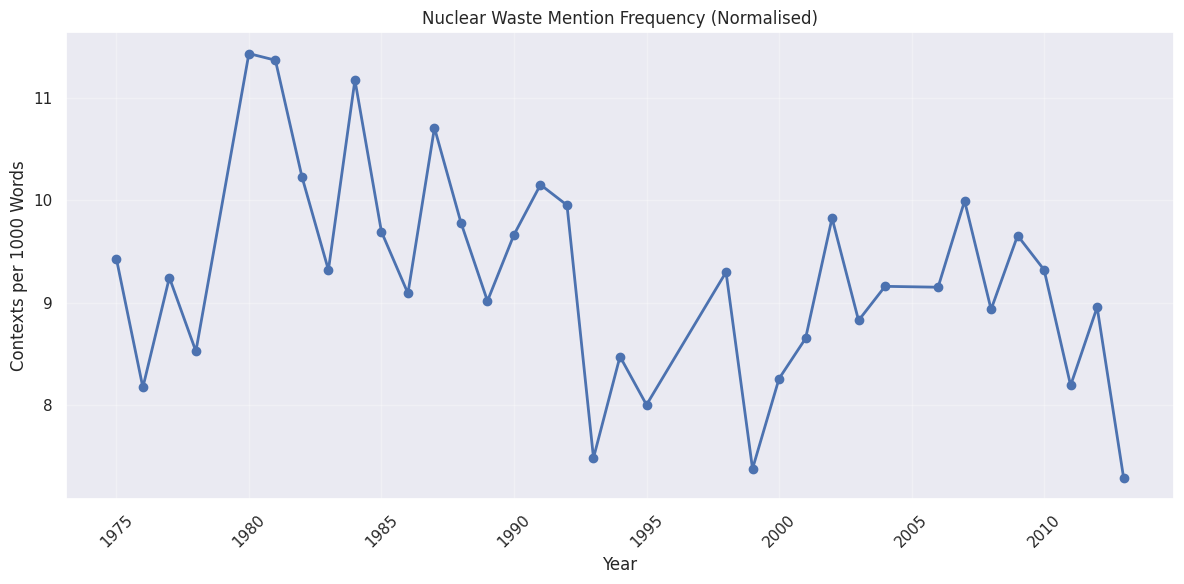

In [6]:
# First we need to get the total word count per year. 
yearly_yap_counts = df_filtered.groupby('year')['context_clean'].apply(
    lambda x: sum(len(text.split()) for text in x)
).rename('total_words')

# And then we count have many contexts appear in a year
yearly_epic_counts = df_filtered['year'].value_counts().sort_index().rename('context_count')

# We combine the context counts so we can see how much yap occurred per year
yearly_stats = pd.DataFrame({
    'context_count': yearly_epic_counts,
    'total_words': yearly_yap_counts
}).fillna(0)

# Now we calculatge the normalised frequency
yearly_stats['contexts_per_1000_words'] = (yearly_stats['context_count'] / yearly_stats['total_words']) * 1000

# Put it into a table
print("Yearly normalized frequencies:")
print(yearly_stats.round(3))

# And we can plot it like we're Palpatine. 
plt.figure(figsize=(12, 6))
plt.plot(yearly_stats.index, yearly_stats['contexts_per_1000_words'], 
         marker='o', linewidth=2, markersize=6)
plt.title('Nuclear Waste Mention Frequency (Normalised)')
plt.xlabel('Year')
plt.ylabel('Contexts per 1000 Words')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## TF-IDF Analysis

Oh boy, now we move onto the fun bit. The TF-IDF vectorisation produces a pretty matrix, and that's why we love it, as described in our method. This will be done using the NLP methods taught in the NLP module. One key element I want to touch on here is the stop words. Given every context with have nuclear waste and radioactive waste, we shall remove them; and we shall also remove a bunch of Commons procedural language because it's basically useless ("friend" is the most evil word to valence measurements). 

1975: disposal (0.168), flowers (0.109), energy (0.108), power (0.105), report (0.095)
1980: disposal (0.124), public (0.087), people (0.082), hazardous (0.077), power (0.073)
1985: disposal (0.168), government (0.159), power (0.111), industry (0.104), committee (0.094)
1990: industry (0.138), reprocessing (0.137), management (0.122), fuel (0.112), spent (0.096)
1995: dounreay (0.193), government (0.134), mox (0.133), reprocessing (0.132), scotland (0.098)
2000: government (0.118), power (0.086), new (0.085), submarines (0.077), environment (0.076)
2005: power (0.150), government (0.145), new (0.122), costs (0.095), disposal (0.094)
2010: power (0.190), disposal (0.148), new (0.135), geological disposal (0.124), geological (0.099)


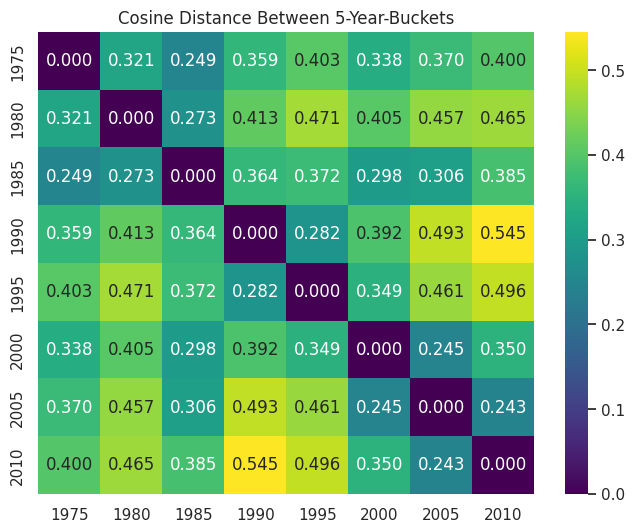

In [7]:
# First we need to create our period based document texts so they can be put together and used in analysis. 
period_texts_very_mature = df_filtered.groupby('period_5yr')['context_clean'].apply(
    lambda x: ' '.join(x)
).reset_index()

# Now we create that stop word list we talked about earlier. I'd love to have made an algorithm that determined these words properly
# But I had an AI (Claude) help generate the Parliamentary procedural terms because I did not know where to start with that. 
custom_stopwords = [
    
    # Nuclear selection terms
    'nuclear waste', 'radioactive waste', 'nuclear', 'waste', 'radioactive', 
    
    # Parliamentary procedure
    'hon', 'honourable', 'friend', 'gentleman', 'gentlemen', 'lady', 'ladies',
    'right hon', 'right honourable', 'hon friend', 'hon gentleman', 'hon lady',
    'mr speaker', 'madam speaker', 'deputy speaker', 'speaker',
    'give way', 'way', 'yield', 'minister', 'secretary',
    'member', 'members', 'house', 'commons',
    'debate', 'answer', 'time', 'today', 'said', 'say', 'says'
]

vectorizer_voiced_by_jason_segel = TfidfVectorizer(
    input='content',
    strip_accents='ascii',
    stop_words='english',
    max_features=500,
    min_df=2,
    ngram_range=(1, 2)
)

# Put the sentences into a table and get them in order as they appear, to get ready to torture-I mean fix them. 
tfidf_matrix = vectorizer_voiced_by_jason_segel.fit_transform(period_texts_very_mature['context_clean'])
feature_names = vectorizer_voiced_by_jason_segel.get_feature_names_out()

# This allows us to remove our custom stop words. 
the_filtered_features = [term for term in feature_names 
                    if not any(stop_term in term.lower() 
                              for stop_term in custom_stopwords)]

# This will allow is to produce indices so we can grab chosen words from the matrix later if needed
feature_indices = [i for i, term in enumerate(feature_names) 
                  if term in the_filtered_features]

# Now Neo will filter the matrix
he_is_the_one = tfidf_matrix[:, feature_indices]

tfidf_df = pd.DataFrame(
    he_is_the_one.todense(),
    columns=the_filtered_features,
    index=period_texts_very_mature['period_5yr']
)

# This will show us the top distances for each 5-year-bucket
for period in sorted(tfidf_df.index):
    top_trumps = tfidf_df.loc[period].sort_values(ascending=False).head(5)
    terms_with_da_scores = [f"{term} ({score:.3f})" for term, score in zip(top_trumps.index, top_trumps.values)]
    print(f"{period}: {', '.join(terms_with_da_scores)}")

john_distances = []
period_labels = list(tfidf_df.index) # For our plot. Our Palpatine plot even

for i in range(len(tfidf_df)):
    john_row_distances = []
    for j in range(len(tfidf_df)):
        cos_dist = distance.cosine(tfidf_df.iloc[i], tfidf_df.iloc[j])
        john_row_distances.append(cos_dist)
    john_distances.append(john_row_distances)

average_height_for_the_time_dataframe = pd.DataFrame(john_distances, columns=period_labels, index=period_labels)

# NOW WE CREATE THE MATRIX YEAHHH (I love Keanu Reaves)
plt.figure(figsize=(8, 6))
sns.heatmap(average_height_for_the_time_dataframe, annot=True, cmap='viridis', fmt='.3f')
plt.title('Cosine Distance Between 5-Year-Buckets')
plt.show()

And that's our TF-IDF done. Now, the main issue is validating our three-eras hypothesis that formed from the TF-iDF (see Findings section).

We can do this with some funky cluster validation. 

## Clustering and TF-IDF Validation


1. FIND OUT WHICH YEARS BUDDY UP BEST FOR A BUDDY COP MOVIE (aka finding the optimum era formation via data driven clustering)
--------------------------------------------------
2 clusters: silhouette score = 0.203
3 clusters: silhouette score = 0.266
4 clusters: silhouette score = 0.164
5 clusters: silhouette score = 0.130
6 clusters: silhouette score = 0.078

Data suggests optimal clusters: 3


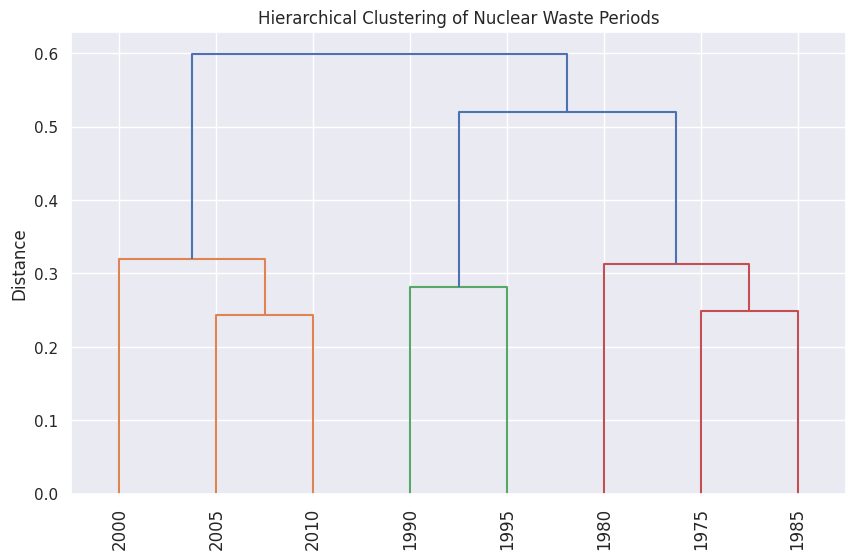

In [8]:
# We're calculating our distances again, mainly as a sanity check
# Isn't a lot of that for anything associated with Parliament, but I thought it best 
# I ran some checks of my own and they match
distance_matrix = squareform(pdist(tfidf_df.values, metric="cosine"))
periods = list(tfidf_df.index)
dist_df = pd.DataFrame(distance_matrix, index=periods, columns=periods)

print("\n1. FIND OUT WHICH YEARS BUDDY UP BEST FOR A BUDDY COP MOVIE (aka finding the optimum era formation via data driven clustering)")
print("-" * 50)

# This will let SciPy glue everything together over and over to form all possible configurations of "eras"
condensed_distances = squareform(distance_matrix)
linkage_matrix = linkage(condensed_distances, method='ward')

silhouette_scores = []
cluster_results = {}

for n_clusters in range(2, 7): # This will try every possible way of splitting the tree into piles less than 7
    clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust') # This will tell us which period falls into which pile
    score = silhouette_score(distance_matrix, clusters, metric='precomputed') # This will give each computation a fairness score that tells us how well each period goes into each pile
    silhouette_scores.append(score) # Save for comparison
    cluster_results[n_clusters] = clusters
    print(f"{n_clusters} clusters: silhouette score = {score:.3f}")

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2 # We add two as the index starts at 0. And we need at minimum 2 piles (hence why we started there)
print(f"\nData suggests optimal clusters: {optimal_clusters}")

# This puts it into a neat dendrogram plot that we can interpret
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=periods, leaf_rotation=90)
plt.title('Hierarchical Clustering of Nuclear Waste Periods')
plt.ylabel('Distance')
plt.show()

Okay, that looks good. But we actually need to compare it to our three-era hypothesis to check that yes, while it visually looks the same, it is actually the same. Or rather, statistically valid. So we need to compare it to the three-era hypothesis. 

In [10]:
# The below is our three-era hypothesis grouping
era_map = {1975: 3, 1980: 3, 1985: 3,
           1990: 2, 1995: 2,
           2000: 1, 2005: 1, 2010: 1}
theoretical_clusters = [era_map[p] for p in periods]
optimal_clusters     = silhouette_scores.index(max(silhouette_scores)) + 2
optimal_data_clusters = cluster_results[optimal_clusters]

# This will compare the two
three_cluster_solution = cluster_results[3]

# Now, the important thing to note about this table is that the optimal table is different to the data drive table
# The data driven table is forced into 3 separate ones like our theoretical one
# When theoretically, the optimal one could be split into 6
# if the numbers are all the same, we're good
print("Period | Theoretical | Data-Driven (forced 3) | Data-Driven (Optimal)")
print("-" * 65)
for i, period in enumerate(periods):
    print(f"{period}  |      {theoretical_clusters[i]}      |       {three_cluster_solution[i]}        |          {optimal_data_clusters[i]}")

# This will calculate the agreement scores
# A rand score basically tells you how similar things are. Which is what we want
agreement_3 = adjusted_rand_score(theoretical_clusters, three_cluster_solution)
agreement_optimal = adjusted_rand_score(theoretical_clusters, optimal_data_clusters)

# The Rand score.
# Iron Fist
# Neat

print(f"\nAgreement with theoretical 3-era framework:")
print(f"  3-cluster solution: {agreement_3:.3f}")
print(f"  Optimal solution:   {agreement_optimal:.3f}")
print(f"  (1.0 = perfect match, 0.0 = random)")



Period | Theoretical | Data-Driven (forced 3) | Data-Driven (Optimal)
-----------------------------------------------------------------
1975  |      3      |       3        |          3
1980  |      3      |       3        |          3
1985  |      3      |       3        |          3
1990  |      2      |       2        |          2
1995  |      2      |       2        |          2
2000  |      1      |       1        |          1
2005  |      1      |       1        |          1
2010  |      1      |       1        |          1

Agreement with theoretical 3-era framework:
  3-cluster solution: 1.000
  Optimal solution:   1.000
  (1.0 = perfect match, 0.0 = random)


Now, just in case we add more samples, we'll run a coherence test to check if all the periods are chronological. This is important because, say we change our sample, then if ANY of them have even the slightly oddity regarding their consecutive nature (one period after the other), it completely destroys the idea of a historical period.

So, this test (though slightly pointless) is here to uphold the most important aspect of the test

In [ ]:
# Again, this will make sure all proposed eras follow a chronological order. This is important because, ya know, eras
def wibbly_wobbly_timey_wimey(periods, clusters):
    period_years = [int(p) for p in periods]
    violations = 0 # Don't mess with time!
    
    for cluster_id in set(clusters):
        cluster_years = [period_years[i] for i, c in enumerate(clusters) if c == cluster_id]
        if len(cluster_years) > 1:
            cluster_years.sort()
            gaps = [cluster_years[i+1] - cluster_years[i] for i in range(len(cluster_years)-1)] # This checks for non consecutive periods
            violations += sum(1 for gap in gaps if gap > 10)
    return violations

print("Temporal coherence:")
for n_clusters in range(2, 6):
    clusters = cluster_results[n_clusters]
    violations = wibbly_wobbly_timey_wimey(periods, clusters)
    print(f"  {n_clusters} clusters: {violations} temporal violations")


Now, we do this to verify one last time that the three-eras hypothesis is viable to continue with the rest of the project with and form the historical contextualisation around.

In [11]:
# This is a Welch T-test. And what it will do is it will check if the ones within the eras are more similar to each other than any other period
# It's a bit like what we did in Corpus 1 actually with the ANOVA test
# The Welch T-test accounts for the fact that different periods have different amounts of variance
# Otherwise you might be comparing an era that is really different to each other, and another that is basically all the same
# Which would destroy a standard t-test

data_era_map = {periods[i]: three_cluster_solution[i] for i in range(len(periods))}

within, between = [], [] # This allows comparison of internal era vs external era
for i, p1 in enumerate(periods):
    for j, p2 in enumerate(periods): # This will ensure it looks at the other periods when selecting a period
        if j <= i: # Have we computed this pair before?
            continue
        d = dist_df.loc[p1, p2] # Gets the distance between the two eras
        if data_era_map[p1] == data_era_map[p2]: # Checks if two periods are in the same era
            within.append(d)
        else:
            between.append(d)

print(f"Within-era mean distance : {np.mean(within):.3f}")
print(f"Between-era mean distance: {np.mean(between):.3f}")
t_stat, p_val = ttest_ind(within, between, equal_var=False)
print(f"Welch t = {t_stat:.2f}, p = {p_val:.4f}")

print("We are so statistically significant right now"
      if p_val < 0.05 else
      "Delete your project write up. NOW")

Within-era mean distance : 0.281
Between-era mean distance: 0.407
Welch t = -5.97, p = 0.0000
We are so statistically significant right now


## Word Embeddings

Now we do some word embeddings. Mainly to check if everything we did was due to words being used for completely different meanings, thus making our entire exercise pointless. Most of this is lifted verbatim from the NLP_Methods course and document, so I'll leave it to stand as is

In [19]:
lemon_teaser = WordNetLemmatizer()

# This will extract the words from the TF-IDF results. 
top_tfidf_words = set()
for period in tfidf_df.index:
    period_top = tfidf_df.loc[period].nlargest(15).index.tolist()
    top_tfidf_words.update(period_top)
target_words = sorted(list(top_tfidf_words))

def better_tokenize_that_context(text):
    if pd.isna(text):
        return []
    tokens = word_tokenize(text.lower())
    tokens = [lemon_teaser.lemmatize(word) for word in tokens 
              if word.isalpha() and len(word) > 2]
    return tokens

# This will create training data for our period-based analysis
period_sentences = {}
for period in sorted(df_filtered['period_5yr'].unique()):
    period_data = df_filtered[df_filtered['period_5yr'] == period]
    sentences = []
    for context in period_data['context_clean']:
        tokens = better_tokenize_that_context(context)
        for i in range(0, len(tokens), 10):
            sentence = tokens[i:i+10]
            if len(sentence) >= 3:
                sentences.append(sentence)
    period_sentences[period] = sentences

# This will train the embedding models
period_models = {}
for period, sentences in period_sentences.items():
    if len(sentences) >= 10:
        try:
            model = Word2Vec(sentences, vector_size=50, window=5, min_count=2, 
                           workers=1, seed=42, epochs=20)
            period_models[period] = model
        except Exception as e:
            print(f"  {period}: Training failed - {e}")

# Analyze semantic stability
word_stability = {}

for target_word in target_words:
    word_vectors = {}

    for period, model in period_models.items():
        if target_word in model.wv:
            word_vectors[period] = model.wv[target_word]

    if len(word_vectors) >= 2:
        periods_available = list(word_vectors.keys())
        similarities = []
 
        for i, period1 in enumerate(periods_available):
            for j, period2 in enumerate(periods_available):
                if i < j:
                    similarity = np.dot(word_vectors[period1], word_vectors[period2]) / (
                        np.linalg.norm(word_vectors[period1]) * np.linalg.norm(word_vectors[period2])
                    )
                    similarities.append(similarity)
        
        if similarities:
            avg_similarity = np.mean(similarities)
            word_stability[target_word] = avg_similarity

# Display key results
if word_stability:
    stable_words = sorted(word_stability.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nMost semantically stable words (consistent meaning):")
    for word, stability in stable_words[:5]:
        print(f"  {word}: {stability:.3f}")
    
    print(f"\nMost semantically shifting words (changing meaning):")
    for word, stability in stable_words[-5:]:
        print(f"  {word}: {stability:.3f}")

# Statistical validation
if word_stability:
    stability_scores = list(word_stability.values())
    
    overall_stability = np.mean(stability_scores)
    random_baseline = 0.5
    
    t_stat, p_val = ttest_1samp(stability_scores, random_baseline)
    print(f"Mean semantic stability: {overall_stability:.3f}")
    print(f"Test vs random baseline (0.5): t = {t_stat:.3f}, p = {p_val:.6f}")
    
    if p_val < 0.05 and overall_stability > random_baseline:
        print("IT'S ALL THE SAME! SEMANTINCALLY IN THE NAME OF CHANGE!")
        print("The core meanings are the same. Don't worry, your results aren't worthless!")
    else:
        print("SCRAP YOU ENTIRE WORKFLOW FOOL!")


Most semantically stable words (consistent meaning):
  scottish: 0.899
  legacy: 0.896
  carbon: 0.896
  scotland: 0.885
  term: 0.884

Most semantically shifting words (changing meaning):
  management: 0.816
  dockyard: 0.813
  state: 0.794
  dumping: 0.791
  select: 0.671
Mean semantic stability: 0.858
Test vs random baseline (0.5): t = 75.043, p = 0.000000
IT'S ALL THE SAME! SEMANTINCALLY IN THE NAME OF CHANGE!
The core meanings are the same. Don't worry, your results aren't worthless!


And that's it. Kinda jumped the shark at the end there but I've got to submit. Ciao!